In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import sys
# Needed for the model class to work inside a Notebook.
os.environ["COBAYA_NOMPI"] = "True"
# Add everything to our paths.
repo = "/pscratch/sd/m/mwhite/AbacusLBG/Cobaya/"
for codedir in ["lss_likelihood","emulator"]:
    sys.path.append(repo+codedir)

In [3]:
# GetDist is resetting the matplotlib backend to 'agg',
# which screws up inline plots.  To get around this we
# need to save the backend here and then reset it.
saved_backend = plt.rcParams["backend"]

In [4]:
from cobaya.yaml          import yaml_load_file
from cobaya.samplers.mcmc import plot_progress
from cobaya.model         import get_model
#
from getdist.mcsamples    import MCSamplesFromCobaya
from getdist.mcsamples    import loadMCSamples
import getdist.plots      as     gdplt
#
matplotlib.use(saved_backend)

### Let's take a look at some chains

In [5]:
#db = "/pscratch/sd/m/mwhite/AbacusLBG/Cobaya/"
#plot_progress(db + "chains/rsd_lcdm")

In [6]:
db   = "/pscratch/sd/m/mwhite/AbacusLBG/Cobaya/"
info = yaml_load_file(db + "lbg_z300_r245_rsd_am.yaml")
print(info['params'].keys())
print(info['output'])

dict_keys(['H0', 'omegam', 'logA', 'sigma8', 'bsig8', 'b2', 'bs', 'b3'])
chains/lbg_z300_r245_rsd_am


In [7]:
#
chains = []
clist  = []
llist  = []
legnd  = []
icol   = 0
for yaml in [\
            "lbg_z300_r240_rsd_am.yaml",\
            "lbg_z300_r240_rsd_H0.yaml",\
            "lbg_z300_r240_rsd_b3.yaml",\
            "lbg_z300_r245_rsd_am.yaml",\
            "lbg_z300_r245_rsd_H0.yaml",\
            ]:
    info= yaml_load_file(db + yaml)
    cc  = loadMCSamples(db + info["output"],no_cache=True,\
                        settings={'ignore_rows':0.3})
    p   = cc.getParams()
    cc.addDerived(p.bsig8/p.sigma8,name='blin',label=r'b_{lin}')
    chains.append(cc)
    #
    col = 'C'+str(icol)
    clist.append(col)
    llist.append({'ls':'-','color':col})
    legnd.append(yaml[:-5])
    icol += 1
#
for cc in chains:
    print('\n'+cc.getName())
    print("R-1=",cc.getGelmanRubin())
    print("Eff. samples ",cc.getEffectiveSamples())
    for k in ["omegam","H0","sigma8","blin","b2","bs"]:
        print( cc.getInlineLatex(k) )


lbg_z300_r240_rsd_am
R-1= 0.011719844550187784
Eff. samples  10693.64072908188
\Omega_\mathrm{m} = 0.294^{+0.012}_{-0.013}
H_0 = 68.54\pm 0.84
\sigma_8 = 0.752\pm 0.031
b_{lin} = 5.04^{+0.26}_{-0.24}
b_2 = 12.7\pm 1.7
b_s = -0.5^{+4.6}_{-3.7}

lbg_z300_r240_rsd_H0
R-1= 0.008918098033212673
Eff. samples  26352.26234427481
\Omega_\mathrm{m} = 0.3059\pm 0.0093
H_0 = 67.53\pm 0.31
\sigma_8 = 0.780\pm 0.026
b_{lin} = 4.86^{+0.25}_{-0.20}
b_2 = 11.1\pm 1.3
b_s = 0.0^{+4.5}_{-3.2}

lbg_z300_r240_rsd_b3
R-1= 0.015688766166984308
Eff. samples  22769.178257666616
\Omega_\mathrm{m} = 0.293\pm 0.012
H_0 = 68.44\pm 0.85
\sigma_8 = 0.747\pm 0.030
b_{lin} = 5.02\pm 0.24
b_2 = 9.3^{+5.1}_{-3.2}
b_s = -1.2^{+4.9}_{-4.1}

lbg_z300_r245_rsd_am
R-1= 0.008077365161083766
Eff. samples  15528.13811932757
\Omega_\mathrm{m} = 0.3086\pm 0.0085
H_0 = 68.03\pm 0.56
\sigma_8 = 0.793\pm 0.017
b_{lin} = 4.10^{+0.11}_{-0.089}
b_2 = 5.77^{+1.5}_{-0.63}
b_s = -5.7^{+2.9}_{-4.5}

lbg_z300_r245_rsd_H0
R-1= 0.00719456995

In [8]:
#for cc in chains:
#    print(cc.getNumSampleSummaryText())

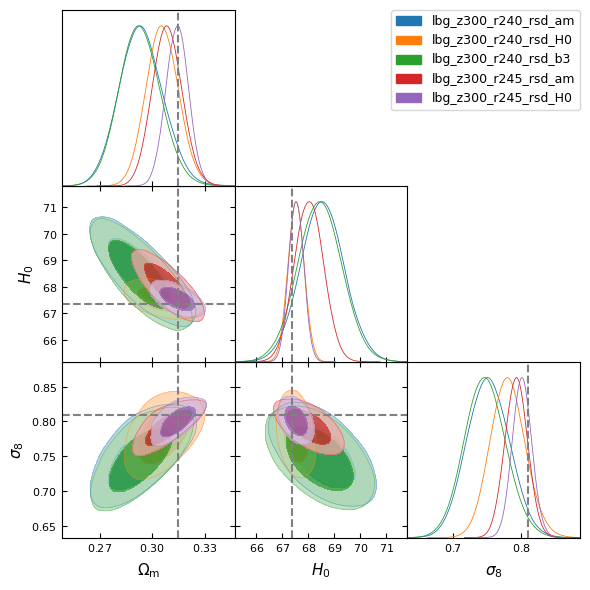

In [9]:
# Do the corner plot.
g = gdplt.get_subplot_plotter()
g.triangle_plot(chains,\
                ["omegam","H0","sigma8"],\
                colors=clist,\
                line_args=llist,\
                legend_labels=legnd,\
                filled=True,alphas=[0.75]*len(chains))
for irow in range(3):
    g.subplots[irow,0].axvline(0.315,color='grey',ls='--')
for irow in range(1,3):
    g.subplots[irow,1].axvline(67.36,color='grey',ls='--')
for irow in range(2,3):
    g.subplots[irow,2].axvline(0.809,color='grey',ls='--')
for icol in range(2):
    g.subplots[2,icol].axhline(0.809,color='grey',ls='--')
for icol in range(1):
    g.subplots[1,icol].axhline(67.36,color='grey',ls='--')
g.export('corner_plot.png')

<Figure size 1000x750 with 0 Axes>

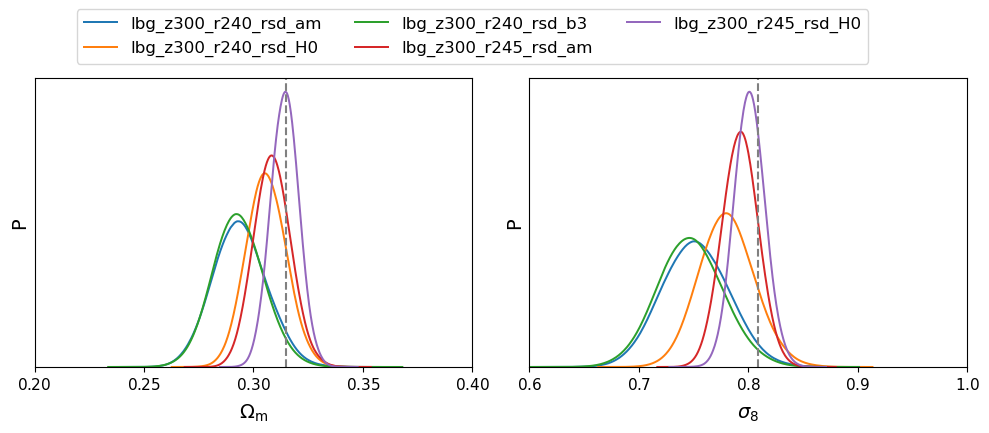

In [10]:
# Look at some 1D posteriors.
if (len(legnd)>3):
    lncol = (len(legnd)+1)//2
else:
    lncol = len(legnd)
g = gdplt.get_single_plotter(width_inch=10)
g.plots_1d(chains,['omegam','sigma8'],nx=2,normalized=True,\
           colors=clist,\
           legend_labels=legnd,legend_ncol=lncol,\
           constrained_layout=True,\
           xlims=[ [0.20,0.40],[0.60,1.00] ]);
g.subplots[0,0].axvline(0.315,color='grey',ls='--')
g.subplots[0,1].axvline(0.809,color='grey',ls='--')
#
g.export("posterior_1d.png")

In [11]:
# Print the values of the parameters in a way easy to cut and paste
# into the LaTeX (with symmetric errors for inline formatting).
#for cc in chains:
#    for k in ["omegam","H0","sigma8"]:
#        out = "${:.3f} \pm {:.3f}$".format(cc.mean(k),cc.std(k))
#        print(out)
#    print('\n')

In [12]:
# Print some limits.
for cc in chains:
    gstats  = cc.getMargeStats().parWithName('sigma8')
    lower68 = gstats.limits[0].lower
    lower95 = gstats.limits[1].lower
    upper68 = gstats.limits[0].upper
    upper95 = gstats.limits[1].upper
    print("\n"+cc.getName())
    print(cc.getInlineLatex('sigma8'))
    print("{:6.3f}<sigma8<{:6.3f} (68CL)".format(lower68,upper68))
    print("{:6.3f}<sigma8<{:6.3f} (95CL)".format(lower95,upper95))


lbg_z300_r240_rsd_am
\sigma_8 = 0.752\pm 0.031
 0.721<sigma8< 0.783 (68CL)
 0.692<sigma8< 0.813 (95CL)

lbg_z300_r240_rsd_H0
\sigma_8 = 0.780\pm 0.026
 0.755<sigma8< 0.806 (68CL)
 0.731<sigma8< 0.833 (95CL)

lbg_z300_r240_rsd_b3
\sigma_8 = 0.747\pm 0.030
 0.717<sigma8< 0.777 (68CL)
 0.689<sigma8< 0.809 (95CL)

lbg_z300_r245_rsd_am
\sigma_8 = 0.793\pm 0.017
 0.776<sigma8< 0.809 (68CL)
 0.760<sigma8< 0.825 (95CL)

lbg_z300_r245_rsd_H0
\sigma_8 = 0.801\pm 0.014
 0.787<sigma8< 0.815 (68CL)
 0.774<sigma8< 0.830 (95CL)


## Model class

Let's investigate things using the model class.

In [13]:
info = yaml_load_file(db + "lbg_z300_r245_rsd.yaml")
model= get_model(info)
print(list(model.parameterization.sampled_params()))

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'stop_on_error']
['H0', 'omegam', 'logA', 'bsig8', 'b2', 'bs', 'alpha0', 'alpha2', 'SN0', 'SN2']


In [14]:
# Set a fiducial point.
pars = {'H0': 68.,\
        'omegam': 0.30624422,\
        'logA': 3.036394}
#
pars['bsig8'] = 3.804
for pref in ['b2','bs','alpha0','alpha2','SN0','SN2']:
    pars[pref] = 0.0

In [15]:
# Force the evaluation of the likelihoods.
model.logposterior(pars)

LogPosterior(logpost=-1423140.442511661, logpriors=[-42.5769537282689], loglikes=array([-1423097.86555793]), derived=[0.8032972446015911], finite=False)

In [16]:
# Just so we know what likelihoods we have:
print("Have likelihoods:")
print(model.likelihood.keys())
# and what they wanted:
print("Model requested:")
print(model.requested())

Have likelihoods:
dict_keys(['rsd_likelihood.FullShapeLikelihood'])
Model requested:
{'rsd_likelihood.Taylor_pk_theory': [{'sigma8':None}, {'taylor_pk_ell_mod':None}]}


In [17]:
# As an example, print the first 5 entires of the observations.
# This could be anything stored in the likelihood class, e.g. C^{-1}
# or the theory or whatever.
for lik in model.likelihood.keys():
    print(lik,"\n",model.likelihood[lik].obs[:5],"\n")

rsd_likelihood.FullShapeLikelihood 
 [51124.01688868 62240.67149515 52588.5598835  40415.15076032
 32336.23139864] 



In [18]:
# Let's look at the best-fit model for the chain.
cc  = loadMCSamples(db + info["output"],no_cache=True,\
                    settings={'ignore_rows':0.3})
pp   = cc.getParams()
ii   = np.argmin(pp.chi2)
print("Best fit model ",ii," has chi^2=",pp.chi2[ii])
#
pars = {}
for k in model.parameterization.sampled_params():
    pars[k] = cc[k][ii]
print(pars)
#
# Force the evaluation of the likelihoods.
mm = model.logposterior(pars)
print(mm)

Best fit model  867192  has chi^2= 28.920274
{'H0': 68.088739, 'omegam': 0.30731008, 'logA': 2.997631, 'bsig8': 3.2284454, 'b2': 4.5568507, 'bs': -9.5874312, 'alpha0': -16.766463, 'alpha2': 2.1464285, 'SN0': 1705.7411, 'SN2': -523.89285}
LogPosterior(logpost=-58.74075566633552, logpriors=[-44.280597655342454], loglikes=array([-14.46015801]), derived=[0.7917854055931158], finite=False)


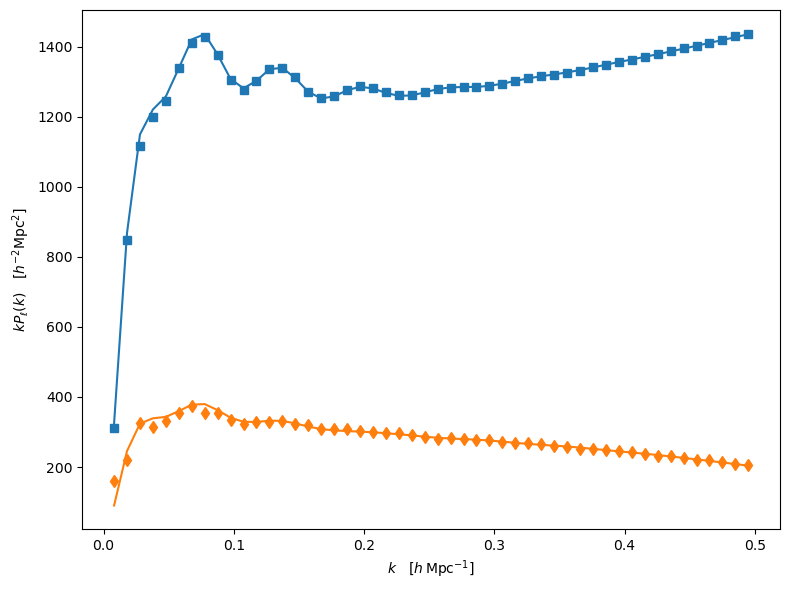

In [19]:
# Make a plot of the data and theory.
lik  ='rsd_likelihood.FullShapeLikelihood'
obs  =model.likelihood[lik].obs
kdat =model.likelihood[lik].kdat
p0dat=model.likelihood[lik].p0dat
p2dat=model.likelihood[lik].p2dat
obs  =model.likelihood[lik].obs
cov  =model.likelihood[lik].cov  ; cov[cov>1e20]=0
p0thy=obs[:kdat.size]
p2thy=obs[kdat.size:]
p0err=np.sqrt(np.diag(cov)[:kdat.size]) # Too small to bother plotting.
p2err=np.sqrt(np.diag(cov)[kdat.size:]) # Too small to bother plotting.
#
fig,ax = plt.subplots(1,1,figsize=(8,6))
#
ax.plot(kdat,kdat*p0dat,'s',color='C0',label=r'$\ell=0$')
ax.plot(kdat,kdat*p2dat,'d',color='C1',label=r'$\ell=2$')
#
ax.plot(kdat,kdat*p0thy,'-',color='C0')
ax.plot(kdat,kdat*p2thy,'-',color='C1')
#
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$k P_\ell(k)\quad [h^{-2}{\rm Mpc}^2]$')
plt.tight_layout()
plt.savefig('best_fit_model.png')

In [20]:
# This tidies up after ourselves, frees up memory, etc.
model.close()

INFO:rsd_likelihood.fullshapelikelihood:Average evaluation time for rsd_likelihood.FullShapeLikelihood: 0.000472123 s  (1 evaluations)


[rsd_likelihood.fullshapelikelihood] Average evaluation time for rsd_likelihood.FullShapeLikelihood: 0.000472123 s  (1 evaluations)


INFO:rsd_likelihood.taylor_pk_theory:Average evaluation time for rsd_likelihood.Taylor_pk_theory: 0.00233477 s  (1 evaluations)


[rsd_likelihood.taylor_pk_theory] Average evaluation time for rsd_likelihood.Taylor_pk_theory: 0.00233477 s  (1 evaluations)


# The end